In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:

# Combine Voyage Prive files
voyageprive_files = glob.glob("../../data/voyageprive_hotels_*.csv", delimiter=';')
voyageprive_data = pd.concat([pd.read_csv(file) for file in voyageprive_files], ignore_index=True)

# Combine Verychic files
verychic_files = glob.glob("../../data/verychic_hotels_*.csv")
verychic_data = pd.concat([pd.read_csv(file) for file in verychic_files], ignore_index=True)


In [3]:
# Clean Voyage Prive data
voyageprive_data['price'] = voyageprive_data['price'].str.extract(r'(\d+\.?\d*)').astype(float)
voyageprive_data.rename(columns={'Country': 'country', 'hotel_name': 'hotel_name', 
                                  'start_date': 'start_date', 'end_date': 'end_date'}, inplace=True)

# Clean Verychic data
verychic_data.rename(columns={'Country': 'country', 'hotel_name': 'hotel_name', 
                               'start_date': 'start_date', 'end_date': 'end_date', 'Price': 'price'}, inplace=True)

# Convert dates to datetime
voyageprive_data['start_date'] = pd.to_datetime(voyageprive_data['start_date'])
voyageprive_data['end_date'] = pd.to_datetime(voyageprive_data['end_date'])
verychic_data['start_date'] = pd.to_datetime(verychic_data['start_date'])
verychic_data['end_date'] = pd.to_datetime(verychic_data['end_date'])


In [4]:
def process_dataframe(df):
    """
    Preprocess the 'hotel_name' column in the dataframe to standardize names by:
    - Converting to lowercase
    - Replacing accented characters with unaccented equivalents
    - Removing spaces, special characters, and digits
    - Removing common keywords like 'hotel'

    Parameters:
        df (pd.DataFrame): Dataframe with a 'hotel_name' column to preprocess.

    Returns:
        pd.DataFrame: Dataframe with the preprocessed 'hotel_name' column.
    """
    df['hotel_name_original'] = df['hotel_name']
    df['hotel_name'] = (
        df['hotel_name']
        .str.lower()
        .str.replace('ô', 'o')
        .str.replace('é', 'e')
        .str.replace('è', 'e')
        .str.replace('hotel', '')
        .str.replace('1', '')
        .str.replace('2', '')
        .str.replace('3', '')
        .str.replace('4', '')
        .str.replace('5', '')
        .str.replace('6', '')
        .str.replace('7', '')
        .str.replace('8', '')
        .str.replace('9', '')
        .str.replace('[^a-zA-Z0-9]', '', regex=True)  # Remove all special characters
    )

    # round dates to seconds to avoid floating point errors
    df['start_date'] = pd.to_datetime(df['start_date']).dt.round('s')
    df['end_date'] = pd.to_datetime(df['end_date']).dt.round('s')
    return df

In [20]:
# Restyled Plot for Daily Overlapping Deals
# plt.figure(figsize=(8, 3))  # Set figure size
# Find overlaps
voyageprive_cleaned = process_dataframe(voyageprive_data)
verychic_cleaned = process_dataframe(verychic_data)


overlapping_deals = pd.merge(voyageprive_cleaned, verychic_cleaned, on='hotel_name', suffixes=('_vp', '_vc'))
overlapping_deals = overlapping_deals[
    (overlapping_deals['start_date_vp'] <= overlapping_deals['end_date_vc']) &
    (overlapping_deals['end_date_vp'] >= overlapping_deals['start_date_vc'])
]


daily_overlaps = overlapping_deals['end_date_vp'].value_counts().sort_index()


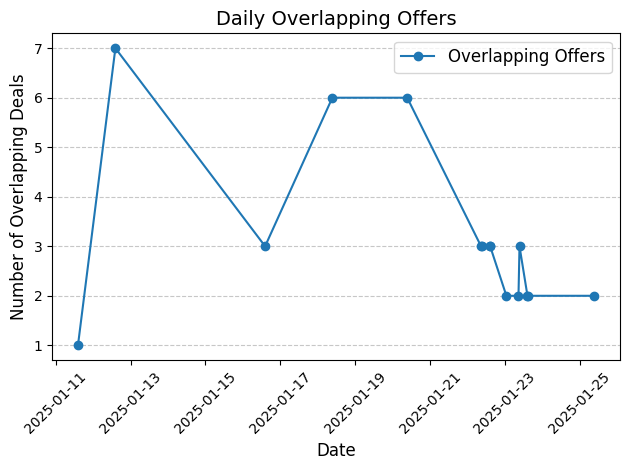

In [21]:


# Plot line with a consistent style
plt.plot(
    daily_overlaps.index, 
    daily_overlaps.values, 
    marker='o', 
    linestyle='-', 
    color='#1f77b4',  # Use a consistent blue color
    label='Overlapping Offers'
)

# Add labels and title
plt.title('Daily Overlapping Offers', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Overlapping Deals', fontsize=12)
# plt.ylim(0, 10)  # Match y-axis limit for consistent view

# Add gridlines to match the bar chart style
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format x-axis ticks
plt.xticks(rotation=45, fontsize=10)

# Add legend for clarity
plt.legend(fontsize=12)

# Ensure layout fits well
plt.tight_layout()

plt.savefig('../../plots/daily_overlapping_offers.png')

# Display the plot
plt.show()


